# Developing with iNNvestigate

In this notebook we present the API behind **iNNvestigate** and show you how to develop your own analysis algorithms! If you haven't done so you should read the notebook [Analyzing with iNNvestigate](introduction.ipynb) first.

The main functionallity of **iNNvestigate's** API is to abstract the tedious, custom backward propagation of (many) analysis algorithms. This should help researchers to focus on algorithm development. In this notebook we will first introduce the concepts behind the API and then show with various examples how one can realize analysis algorithms with **iNNvestigate**.

## Concepts

### Computational graphs

We assume that the reader is familiar with the main concepts of neural networks like forward and backward propagation.
In many computational frameworks the forward pass along the layers of a neural network is realized with the concept of a computational graph.

Such graph typically contain two types of nodes: tensors and operations. An operation node takes incoming edges from its input tensors and has outgoing edges towards its output tensors. Tensors are never directly connected with tensors and operations are never directly connected with operations.

Depending on the granularity one can encode the operations in a neural network in various ways. In this library we follow and make intensive use of the conecpt of a ["layer node"](https://keras.io/getting-started/functional-api-guide/#the-concept-of-layer-node) in the Keras documentation. It is important to understand this concept to follow the rest of this notebook!

#### Why Keras?

There are several choices for deep learning frameworks. We chose Keras as base because it offers a high level interface and convention to approach to neural network models. While, for example, in Tensorflow, MxNet, or PyTorch one can implement a ReLU-activation function in many ways, in Keras it is typically realized with the `keras.activations.relu` function. Relying on such conventions and limiting our library to built-in Keras layers allows to offer better usability: the user can simply pass a Keras model and the library will take care of the rest.

### Backward propagation

Many predicition analysis methods are realized by a (custom) backward propagation from the output neuron to the input.
The basic principle behind these methods is the same as for the gradient backward propagation, which uses the chain-rule to propagate gradients backward. This means that in order to compute the gradient (or any such analysis) one creates a computational graph that maps the output back to the input (and any intermediate tensor).

In **iNNvestigate** this backward mapping is done in the background. The developer only needs to specify how a "layer node" should be "reverted" or the backward pass at a node should be done, while the tedious handling of the whole graph is done by the library.

In more detail, to create a custom backward pass one needs to specify:

* how the backpropagation should be initialized.
  * E.g., the gradient backward propagation is initialized by starting with a 1, while Deconvnet starts with the function value at the output neuron.
* how each layer should be reverted.
  * E.g., to compute the gradient one would apply the chain rule.
  
The API will take care of storing intermediate tensors, the backward pass is done in the right order, Keras specifics and more.




## Preparation

-----

**To use this notebook please download the example images using the following script:**

`innvestigate/examples/images/wget_imagenet_2011_samples.sh`

-----

To show you hands-on how to use **iNNvestigate** we now import all needed modules and load a VGG16 model:

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%matplotlib inline

import imp
import numpy as np
import matplotlib.pyplot as plot
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as kbackend
import tensorflow.keras.layers as klayers
import tensorflow.keras.models as kmodels
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.layers as ilayers
import innvestigate.backend as ibackend
import innvestigate.backend.checks as kchecks
import innvestigate.backend.graph as kgraph

# Use utility libraries to focus on relevant iNNvestigate routines.
import utils as eutils
import utils.imagenet as imagenetutils

In [3]:
# Build the model.
model = VGG16()
model.compile(optimizer="adam", loss="categorical_crossentropy")

# Handle input depending on model.
channels_first = kbackend.image_data_format() == "channels_first"
color_conversion = "BGRtoRGB"  # keras.applications use BGR format

We want to analyze the pre-softmax activations:

In [4]:
# Create model without trailing softmax
model_wo_sm = innvestigate.model_wo_softmax(model)

Finally, we load also some sample images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


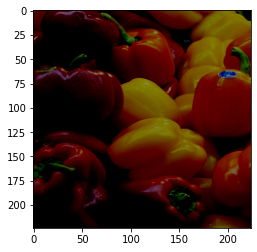

In [5]:
# Get some example test set images.
image_shape = model.input_shape[1:]
images, label_to_class_name = eutils.get_imagenet_data(image_shape[0])

if not len(images):
    raise Exception(
        "Please download the example images using: "
        "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'"
    )

# Choose a sample image and add batch axis
image = images[0][0][None, :, :, :]
# Preprocess it for VGG16
image_pp = preprocess_input(image)
# Displaying the image
plot.imshow(image[0] / 255)
plot.show()

## Functionallity

Now let's start! First we will introduce the main interfaces and then how the concepts above are realized. In the end we show some useful routines for developing algorithms.

### Bascis

#### Interfaces

The basic, abstract interface of an analyzer is given by:

In [6]:
class AnalyzerBase(object):
    """The basic interface of an iNNvestigate analyzer.

    This class defines the basic interface for analyzers:
    >>> model = create_keras_model()
    >>> a = Analyzer(model)
    >>> a.fit(X_train)  # If analyzer needs training.
    >>> analysis = a.analyze(X_test)
    >>>
    >>> state = a.save()
    >>> a_new = A.load(*state)
    >>> analysis = a_new.analyze(X_test)

    :param model: A Keras model.
    :param disable_model_checks: Do not execute model checks that enforce
      compatibility of analyzer and model.

    .. note:: To develop a new analyzer derive from
      :class:`AnalyzerNetworkBase`.
    """

    def __init__(self, model, disable_model_checks=False):
        pass

    def analyze(self, X):
        """
        Analyze the behavior of model on input `X`.

        :param X: Input as expected by model.
        """
        raise NotImplementedError()

This class contains some basic functionallity like storing the model and, if needed, checking if the passed model is compatible with the analysis algorithm (more on that in the section "Additional").

To implement a custom analyzer one can derive from the `AnalyzerNetworkBase` class and implement the function `_create_analysis`. This function takes a model and should build an analysis network that maps the model outputs back to the model inputs:

In [7]:
class AnalyzerNetworkBase(AnalyzerBase):
    """Convenience interface for analyzers.

    This class provides helpful functionality to create analyzer's.
    Basically it:

    * takes the input model and adds a layer that selects
      the desired output neuron to analyze.
    * passes the new model to :func:`_create_analysis` which should
      return the analysis as Keras tensors.
    * compiles the function and serves the output to :func:`analyze` calls.
    * allows :func:`_create_analysis` to return tensors
      that are intercept for debugging purposes.

    :param neuron_selection_mode: How to select the neuron to analyze.
      Possible values are 'max_activation', 'index' for the neuron
      (expects indices at :func:`analyze` calls), 'all' take all neurons.
    :param allow_lambda_layers: Allow the model to contain lambda layers.
    """

    def _create_analysis(self, model, stop_analysis_at_tensors=[]):
        """
        Interface that needs to be implemented by a derived class.

        This function is expected to create a Keras graph that creates
        a custom analysis for the model inputs given the model outputs.

        :param model: Target of analysis.
        :param stop_analysis_at_tensors: A list of tensors where to stop the
          analysis. Similar to stop_gradient arguments when computing the
          gradient of a graph.
        :return: Either one-, two- or three-tuple of lists of tensors.
          * The first list of tensors represents the analysis for each
            model input tensor. Tensors present in stop_analysis_at_tensors
            should be omitted.
          * The second list, if present, is a list of debug tensors that will
            be passed to :function:`_handle_debug_output` after the analysis
            is executed.
          * The third list, if present, is a list of constant input tensors
            added to the analysis model.
        """
        raise NotImplementedError()

The function should return for each input of the model an analysis tensor. *The tensors should be created by using Keras layers,* because the analysis tensors will be used to create a Keras model.

This class also takes care of selecting the right output neuron.
For more details see the class docstring.

#### ReverseAnalyzerBase

The scope of the classes above is merely to provide a common interface. A more advanced and practical starting point for an implementation is given with the class `ReveseAnalyzerBase`.

This class already implements the function `_create_analysis`. In this case the function executes a backward pass, which is done as described in the section "Backward propagation" above.

To use this class one can implement the two methods `_head_mapping` and `_default_reverse_mapping` to initialize the backward pass and define a default reverse mapping:

In [8]:
class ReverseAnalyzerBase(AnalyzerNetworkBase):
    """Convenience class for analyzers that revert the model's structure.

    This class contains many helper functions around the graph
    reverse function :func:`innvestigate.utils.keras.graph.reverse_model`.

    The deriving classes should specify how the graph should be reverted
    by implementing the following functions:

    * :func:`_reverse_mapping(layer)` given a layer this function
      returns a reverse mapping for the layer as specified in
      :func:`innvestigate.utils.keras.graph.reverse_model` or None.

      This function can be implemented, but it is encouraged to
      implement a default mapping and add additional changes with
      the function :func:`_add_conditional_reverse_mapping` (see below).
      * The default behavior is find a conditional mapping (see below),
        if none is found, :func:`_default_reverse_mapping` is applied.
    * :func:`_default_reverse_mapping` defines the default
      reverse mapping.
    * :func:`_head_mapping` defines how the outputs of the model
      should be instantiated before the are passed to the reversed
      network.

    Furthermore other parameters of the function
    :func:`innvestigate.utils.keras.graph.reverse_model` can
    be changed by setting the according parameters of the
    init function:

    ...
    """

    def _reverse_mapping(self, layer):
        """
        This function should return a reverse mapping for the passed layer.

        If this function returns None, :func:`_default_reverse_mapping`
        is applied.

        :param layer: The layer for which a mapping should be returned.
        :return: The mapping can be of the following forms:
          * A function of form (A) f(Xs, Ys, reversed_Ys, reverse_state)
            that maps reversed_Ys to reversed_Xs (which should contain
            tensors of the same shape and type).
          * A function of form f(B) f(layer, reverse_state) that returns
            a function of form (A).
          * A :class:`ReverseMappingBase` subclass.
        """
        pass

    def _default_reverse_mapping(self, Xs, Ys, reversed_Ys, reverse_state):
        """
        Fallback function to map reversed_Ys to reversed_Xs
        (which should contain tensors of the same shape and type).
        """
        pass

    def _head_mapping(self, X):
        """
        Map output tensors to new values before passing
        them into the reverted network.
        """
        pass

Many analysis methods apply different propagation algorithms depending on the layer type. This is reflected by this interface:

In [9]:
class ReverseAnalyzerBase(AnalyzerNetworkBase):
    def _add_conditional_reverse_mapping(
        self, condition, mapping, priority=-1, name=None
    ):
        """
        This function should return a reverse mapping for the passed layer.

        If this function returns None, :func:`_default_reverse_mapping`
        is applied.

        :param condition: Condition when this mapping should be applied.
          Form: f(layer) -> bool
        :param mapping: The mapping can be of the following forms:
          * A function of form (A) f(Xs, Ys, reversed_Ys, reverse_state)
            that maps reversed_Ys to reversed_Xs (which should contain
            tensors of the same shape and type).
          * A function of form f(B) f(layer, reverse_state) that returns
            a function of form (A).
          * A :class:`ReverseMappingBase` subclass.
        :param priority: The higher the earlier the condition gets
          evaluated.
        :param name: An identifying name.
        """
        pass

`ReverseAnalyzerBase` will first try to match a registered, conditional mapping and, if none applies, fall back to `default_reverse_mapping`.

In the rest of the tutorial we will show how to use this base class.

In [10]:
# Reimport the actual class
from innvestigate.analyzer.reverse_base import ReverseAnalyzerBase

### Default backward pass

The API will package the created backward pass in a Keras model and therefore each propagation step needs to be created by Keras layers. In this first example we implement the gradient for a model solely composed of dense, linear layers:

In [11]:
class Example1(ReverseAnalyzerBase):
    def _default_reverse_mapping(self, Xs, Ys, reversed_Ys, reverse_state):
        # Create dense layer that applies the transpose of the forward pass
        layer = reverse_state["layer"]
        weight = layer.get_weights()[0]
        dense_transposed = keras.layers.Dense(weight.shape[0])
        dense_transposed.set_weights([weight.T])

        # Apply the layer
        reversed_Xs = dense_transposed(reversed_Ys)
        return reversed_Xs

    def _head_mapping(self, X):
        """
        Initialize the mapping with ones.
        """
        return ilayer.OnesLike()(X)

This shows to basic idea of the propagation step. Now, to implement a full gradient backward propagation, we will rely on the chain rule and automatic differentiation. This makes the code cleaner and allows to treat different layers with one code fragement, e.g., in this case dense and convolutional layers:

In [12]:
class Example2(ReverseAnalyzerBase):
    def _default_reverse_mapping(self, Xs, Ys, reversed_Ys, reverse_state):
        # Apply the chain rule
        reversed_Xs = ibackend.gradients(Xs, Ys, reversed_Ys)
        return reversed_Xs

    def _head_mapping(self, X):
        """
        Initialize the mapping with ones.
        """
        return ilayers.OnesLike()(X)

And apply it to our VGG16 model:

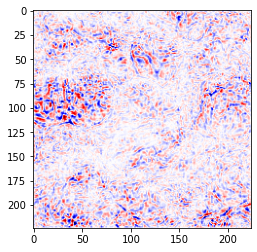

In [13]:
analyzer = Example2(model_wo_sm)
a = analyzer.analyze(image_pp)

# Postprocess
a = imagenetutils.postprocess(a, color_conversion, channels_first)
# Displaying the gradient
plot.imshow(imagenetutils.heatmap(a)[0])
plot.show()

In the next section we will extend this example to implement Guided Backprop!

### Conditional changes to the backward pass

Guided Backprop applies the same algorithm as gradient backpropagation, except that the propagation is initialized with the final function value instead of ones and that each time a ReLU-activation is applied also on the backward pass a ReLU-activation is applied. This is done to keep the signal in the original value range of the forward pass:

In [14]:
# We extend Example 2 with a conditional mapping
class Example3(ReverseAnalyzerBase):
    def _default_reverse_mapping(self, Xs, Ys, reversed_Ys, reverse_state):
        return ibackend.gradients(Xs, Ys, reversed_Ys)

    def _head_mapping(self, X):
        # Keeping the output signal
        return X

    def guided_backprop_mapping(self, Xs, Ys, reversed_Ys, reverse_state):
        activation = keras.layers.Activation("relu")
        # Apply relus conditioned on backpropagated values.
        reversed_Ys = ibackend.apply(activation, reversed_Ys)

        # Apply gradient of forward pass.
        return ibackend.gradients(Xs, Ys, reversed_Ys)

    def _create_analysis(self, *args, **kwargs):
        self._add_conditional_reverse_mapping(
            # Apply to all layers that contain a relu activation
            lambda layer: kchecks.contains_activation(layer, "relu"),
            self.guided_backprop_mapping,
            name="guided_backprop_reverse_relu_layer",
        )

        return super()._create_analysis(*args, **kwargs)

And we apply it again to our VGG16 model:

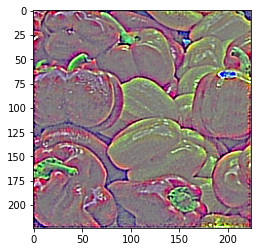

In [15]:
analyzer = Example3(model_wo_sm)
a = analyzer.analyze(image_pp)

# Postprocess
a = imagenetutils.postprocess(a, color_conversion, channels_first)
# Displaying the gradient
plot.imshow(imagenetutils.bk_proj(a)[0])
plot.show()

### Keras layer nodes

A Keras "layer node" can be applied many times. The above examples revert or back proagate each of these indiviually. In some cases it can be computationally more efficient or even necessary to bundle all the back propagations for a single layer node. This can be done by implementing the interface ``ReverseMappingBase``, which then gets initialized once for each layer node and applied for each backward pass of the layer's applications.

We use this to implement LRP-Z for VGG16 (for more complex networks additional steps need to be done):

In [16]:
class ZRule(kgraph.ReverseMappingBase):
    """
    Basic LRP decomposition rule (for layers with weight kernels),
    which considers the bias a constant input neuron.
    """

    def __init__(self, layer, state, bias=True):
        # Copy forward layer, but without activations
        self._layer_wo_act = kgraph.copy_layer_wo_activation(
            layer, keep_bias=bias, name_template="reversed_kernel_%s"
        )

    def apply(self, Xs, Ys, Rs, reverse_state):
        # Get activations.
        Zs = ibackend.apply(self._layer_wo_act, Xs)
        # Divide incoming relevance by the activations.
        tmp = [ilayers.SafeDivide()([a, b]) for a, b in zip(Rs, Zs)]
        # Propagate the relevance to input neurons
        # using the gradient.
        tmp = ibackend.gradients(Xs, Zs, tmp)
        # Re-weight relevance with the input values.
        return [keras.layers.Multiply()([a, b]) for a, b in zip(Xs, tmp)]

And create a new analyzer:

In [17]:
class LRP_Z_for_VGG(ReverseAnalyzerBase):
    def _default_reverse_mapping(self, Xs, Ys, reversed_Ys, reverse_state):
        return ibackend.gradients(Xs, Ys, reversed_Ys)

    def _head_mapping(self, X):
        # Keeping the output signal
        return X

    def _create_analysis(self, *args, **kwargs):
        self._add_conditional_reverse_mapping(
            # Apply to all layers that contain a kernel
            lambda layer: kchecks.contains_kernel(layer),
            ZRule,
            name="z_rule",
        )

        return super()._create_analysis(*args, **kwargs)

And show the result:

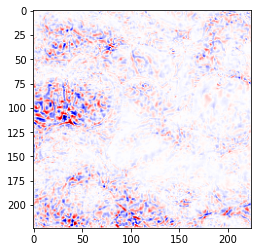

In [18]:
analyzer = LRP_Z_for_VGG(model_wo_sm)
a = analyzer.analyze(image_pp)

# Postprocess
a = imagenetutils.postprocess(a, color_conversion, channels_first)
# Displaying the gradient
plot.imshow(imagenetutils.heatmap(a)[0])
plot.show()

## Additional

### Network compatibility

Not all methods work on all network structures. E.g., most methods cannot handle softmax outputs, other work only with ReLU activation functions.

One can check if a passed model does not confirm with the method's assumption by passing a condition and a message like this:

In [19]:
class Example4(Example3):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._add_model_check(
            lambda layer: kchecks.contains_activation(layer, activation="softmax"),
            "This analysis method does not support softmax layers.",
            check_type="exception",
        )
        self._do_model_checks()


try:
    analyzer = Example4(model)
except innvestigate.NotAnalyzeableModelException:
    print("We should not pass models with a softmax.")

We should not pass models with a softmax.


The condition gets tested on each layer of the network and if it holds the either a warning is printed or an exception raised.

The common check for a softmax activation can be done by calling this helper function: `_add_model_softmax_check`

### Debug routines

To ease the debugging the API provides a few helpful flags.

When setting `reverse_verbose` the API will print information about the backward pass:

In [20]:
analyzer = Example3(model_wo_sm, reverse_verbose=True)
a = analyzer.analyze(image_pp)

Reverse model: <keras.engine.functional.Functional object at 0x12aac72e0>
[NID: 22] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x12a739df0>
[NID: 21] Reverse layer-node <keras.layers.core.dense.Dense object at 0x109c64070>
[NID: 20] Reverse layer-node <keras.layers.core.dense.Dense object at 0x12a206d90>
[NID: 19] Reverse layer-node <keras.layers.core.dense.Dense object at 0x12a2067c0>
[NID: 18] Reverse layer-node <keras.layers.core.flatten.Flatten object at 0x12a1f16a0>
[NID: 17] Reverse layer-node <keras.layers.pooling.MaxPooling2D object at 0x12a1f9df0>
[NID: 16] Reverse layer-node <keras.layers.convolutional.Conv2D object at 0x12a1e3e50>
[NID: 15] Reverse layer-node <keras.layers.convolutional.Conv2D object at 0x12a1e35b0>
[NID: 14] Reverse layer-node <keras.layers.convolutional.Conv2D object at 0x12a1cd880>
[NID: 13] Reverse layer-node <keras.layers.pooling.MaxPooling2D object at 0x12a1d4fd0>
[NID: 12] Reverse layer-node <keras.layers.convolutional.Conv2D

The flag `reverse_check_min_max_values` triggers the printing of min and max values for each tensor created in the backward pass. Note that the NodeID and TensorID corresponds to the values from the verbose print above:

In [21]:
analyzer = Example3(model_wo_sm, reverse_check_min_max_values=True)
a = analyzer.analyze(image_pp)

Minimum values in tensors: ((NodeID, TensorID), Value) - [((-1, 0), 19.618088), ((0, 0), -0.10408281), ((1, 0), -0.0043831347), ((2, 0), -0.0038187366), ((3, 0), -0.0038187366), ((4, 0), -0.001016322), ((5, 0), -0.0008965211), ((6, 0), -0.0008965211), ((7, 0), -0.000604749), ((8, 0), -0.00040961956), ((9, 0), -0.00080954446), ((10, 0), -0.00080954446), ((11, 0), -0.00077044417), ((12, 0), -0.0014484077), ((13, 0), -0.0035186883), ((14, 0), -0.0035186883), ((15, 0), -0.009554004), ((16, 0), -0.01459613), ((17, 0), -0.04027512), ((18, 0), -0.04027512), ((19, 0), -0.04027512), ((20, 0), -0.35644722), ((21, 0), -0.46572432), ((22, 0), 0.0)]
Maximum values in tensors: ((NodeID, TensorID), Value) - [((-1, 0), 19.618088), ((0, 0), -0.10408281), ((1, 0), -0.0043831347), ((2, 0), -0.0038187366), ((3, 0), -0.0038187366), ((4, 0), -0.001016322), ((5, 0), -0.0008965211), ((6, 0), -0.0008965211), ((7, 0), -0.000604749), ((8, 0), -0.00040961956), ((9, 0), -0.00080954446), ((10, 0), -0.00080954446), 

Similarly the flag `reverse_check_finite` checks if all values in backward pass tensors are finite. If not a message will be printed:

In [22]:
analyzer = Example3(model_wo_sm, reverse_check_finite=True)
a = analyzer.analyze(image_pp)

To have full access on the intermediate state of the backward pass one can set the flag `reverse_keep_tensors`, which indicates to store all tensors in a nested dictionaries, where the key for the first level are the NodeIDs and for the second level the TensorIDs:

In [23]:
analyzer = Example3(model_wo_sm, reverse_keep_tensors=True)
a = analyzer.analyze(image_pp)

print("(NodeID, TensorID) - min - max value")
for k, v in analyzer._reversed_tensors:
    print(k, np.min(v), np.max(v))

(NodeID, TensorID) - min - max value
(-1, 0) 19.618088 19.618088
(0, 0) -0.10408281 0.072629414
(1, 0) -0.0043831347 0.0072343247
(2, 0) -0.0038187366 0.0039775767
(3, 0) -0.0038187366 0.0039775767
(4, 0) -0.001016322 0.0024114659
(5, 0) -0.0008965211 0.0035577556
(6, 0) -0.0008965211 0.0035577556
(7, 0) -0.000604749 0.0031908685
(8, 0) -0.00040961956 0.0016976914
(9, 0) -0.00080954446 0.0024250739
(10, 0) -0.00080954446 0.0024250739
(11, 0) -0.00077044417 0.0021209065
(12, 0) -0.0014484077 0.0022497515
(13, 0) -0.0035186883 0.005762716
(14, 0) -0.0035186883 0.005762716
(15, 0) -0.009554004 0.013731454
(16, 0) -0.01459613 0.009986189
(17, 0) -0.04027512 0.113524914
(18, 0) -0.04027512 0.113524914
(19, 0) -0.04027512 0.113524914
(20, 0) -0.35644722 0.19827464
(21, 0) -0.46572432 0.55148387
(22, 0) 0.0 19.618088


For more flags and details we refer to the classe definition of `ReverseAnalyzerBase`.